In [1]:
package_path = '../input/pytorch-image-models/pytorch-image-models-master' #'../input/efficientnet-pytorch-07/efficientnet_pytorch-0.7.0'
import sys; sys.path.append(package_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import os, gc
import random, math, numbers
import time
import warnings

warnings.filterwarnings("ignore")

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable, detect_anomaly
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
from torch.cuda.amp import autocast, GradScaler
import timm

from PIL import Image, ImageOps, ImageEnhance
import numbers
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#from efficientnet_pytorch import EfficientNet

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold

In [5]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [6]:
def worker_init_fn(worker_id):
    torch.manual_seed(worker_id)
    random.seed(worker_id)
    np.random.seed(worker_id)
    torch.cuda.manual_seed(worker_id)

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False

In [8]:
seeds = 777
torch.manual_seed(seeds)
random.seed(seeds)
np.random.seed(seeds)
torch.cuda.manual_seed(seeds)
if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False

In [9]:
base_dir = "../input/cassava-leaf-disease-classification"

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 訓練データ抽出

In [11]:
train = pd.read_csv(f"{base_dir}/train.csv")

In [12]:
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


# Dataset

In [13]:
class Cassava_Dataset(Dataset):
    
    def __init__(self, data_root, input_data, transforms=None):
        self.data_root = data_root
        self.df = input_data
        self.transforms = transforms
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.df.loc[idx]["label"]
          
        path = "{}/{}".format(self.data_root, self.df.iloc[idx]['image_id'])
        
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transforms:
            img = self.transforms(image=img)['image']
        else:
            img = torch.FloatTensor(img)
        return img, label
        
        
def collate_fn(batch):
    images = list()
    labels = list()
    for b in batch:
        images.append(b[0])
        labels.append(b[1])
    images = torch.stack(images, dim=0)
    labels = torch.tensor(labels)

    return images, labels

In [14]:
def get_train_transform():
    return A.Compose([
            A.RandomResizedCrop(512, 512),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            A.CoarseDropout(p=0.5),
            A.Cutout(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transform():
    return Compose([
            A.Resize(512, 512),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

# Check

In [15]:
train_dataset = Cassava_Dataset(f"{base_dir}/train_images", train, get_train_transform())

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          collate_fn=collate_fn, worker_init_fn=worker_init_fn(seeds))

In [16]:
images, targets = next(iter(train_loader))

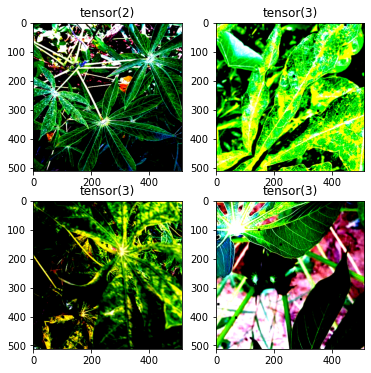

In [17]:
plt.figure(figsize=(6, 6))
for i in range(images.shape[0]):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title(targets[i])
plt.show()

# Bulid_Model

In [18]:
#model = CassvaImgClassifier("tf_efficientnet_b4_ns", train.label.nunique(), pretrained=True).to(device)

In [19]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        backbone = timm.create_model(model_arch, pretrained=pretrained)
        n_features = backbone.classifier.in_features
        self.model = nn.Sequential(*backbone.children())[:-2]
        self.classifier = nn.Linear(n_features, n_class)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
    def forward(self, x):
        feats = self.model(x)
        x = self.pool(feats).view(x.size(0), -1)
        x = self.classifier(x)
        return x, feats

# Snapmix

In [20]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def get_spm(input,target,model):
    imgsize = (512, 512)
    bs = input.size(0)
    with torch.no_grad():
        output,fms = model(input)
        clsw = model.classifier
        weight = clsw.weight.data
        bias = clsw.bias.data
        weight = weight.view(weight.size(0),weight.size(1),1,1)
        fms = F.relu(fms)
        poolfea = F.adaptive_avg_pool2d(fms,(1,1)).squeeze()
        clslogit = F.softmax(clsw.forward(poolfea))
        logitlist = []
        for i in range(bs):
            logitlist.append(clslogit[i,target[i]])
        clslogit = torch.stack(logitlist)

        out = F.conv2d(fms, weight, bias=bias)

        outmaps = []
        for i in range(bs):
            evimap = out[i,target[i]]
            outmaps.append(evimap)

        outmaps = torch.stack(outmaps)
        if imgsize is not None:
            outmaps = outmaps.view(outmaps.size(0),1,outmaps.size(1),outmaps.size(2))
            outmaps = F.interpolate(outmaps,imgsize,mode='bilinear',align_corners=False)

        outmaps = outmaps.squeeze()

        for i in range(bs):
            outmaps[i] -= outmaps[i].min()
            outmaps[i] /= outmaps[i].sum()


    return outmaps,clslogit


def snapmix(input, target, alpha, model=None):

    r = np.random.rand(1)
    lam_a = torch.ones(input.size(0))
    lam_b = 1 - lam_a
    target_b = target.clone()

    if True:
        wfmaps,_ = get_spm(input, target, model)
        bs = input.size(0)
        lam = np.random.beta(alpha, alpha)
        lam1 = np.random.beta(alpha, alpha)
        rand_index = torch.randperm(bs).cuda()
        wfmaps_b = wfmaps[rand_index,:,:]
        target_b = target[rand_index]

        same_label = target == target_b
        bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
        bbx1_1, bby1_1, bbx2_1, bby2_1 = rand_bbox(input.size(), lam1)

        area = (bby2-bby1)*(bbx2-bbx1)
        area1 = (bby2_1-bby1_1)*(bbx2_1-bbx1_1)

        if  area1 > 0 and  area>0:
            ncont = input[rand_index, :, bbx1_1:bbx2_1, bby1_1:bby2_1].clone()
            ncont = F.interpolate(ncont, size=(bbx2-bbx1,bby2-bby1), mode='bilinear', align_corners=True)
            input[:, :, bbx1:bbx2, bby1:bby2] = ncont
            lam_a = 1 - wfmaps[:,bbx1:bbx2,bby1:bby2].sum(2).sum(1)/(wfmaps.sum(2).sum(1)+1e-8)
            lam_b = wfmaps_b[:,bbx1_1:bbx2_1,bby1_1:bby2_1].sum(2).sum(1)/(wfmaps_b.sum(2).sum(1)+1e-8)
            tmp = lam_a.clone()
            lam_a[same_label] += lam_b[same_label]
            lam_b[same_label] += tmp[same_label]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
            lam_a[torch.isnan(lam_a)] = lam
            lam_b[torch.isnan(lam_b)] = 1-lam

    return input,target,target_b,lam_a.cuda(),lam_b.cuda()

In [21]:
class SnapMixLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, criterion, outputs, ya, yb, lam_a, lam_b):
        loss_a = criterion(outputs, ya)
        loss_b = criterion(outputs, yb)
        loss = torch.mean(loss_a * lam_a + loss_b * lam_b)
        return loss

# Train_module

In [22]:
def model_training(input_model, training_data, criterion, criterion2, num_update):
    total_batch = int(len(training_data)/num_update)
    input_model.train()
    #訓練プロセス
    train_loss, time_list = [], []
    
    all_data = len(training_data)
    for process, (images, labels) in enumerate(training_data):
        time_1 = time.time()
        images = images.to(device)
        labels = labels.to(device)
        with autocast():
            rand = np.random.rand()
            if rand > (1.0-SNAPMIX_PCT):
                images, ya, yb, lam_a, lam_b = snapmix(images, labels, SNAPMIX_ALPHA, input_model)
                outputs, _ = input_model(images)
                loss = criterion2(criterion, outputs, ya, yb, lam_a, lam_b)
            else:
                outputs, _ = input_model(images)
                loss = torch.mean(criterion(outputs, labels))
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        grad_norm = torch.nn.utils.clip_grad_norm_(input_model.parameters(), 1000)
            
        loss = loss.item()
        train_loss.append(loss)
        time_list.append(time.time()-time_1)
        if (process % total_batch == 0) | (process == len(training_data)):
            remaining_time = np.mean(time_list)*(all_data-(process+1))
            minute, second = int(remaining_time//59), int(remaining_time%60)
            print('\rtrain_loss: {:.4f} | 残り{:02d}:{:02d} '.format(np.mean(train_loss), minute, second), end='')
    return input_model
                
        
#検証プロセス
def model_validation(input_model, validation_data, criterion):
    input_model.eval()
    valid_loss = []
    correct = 0
    valid_time = time.time()
    for process, (images, labels) in enumerate(validation_data):
        images = images.to(device)
        labels = labels.to(device)
        outputs, _ = input_model(images)
        loss = criterion(outputs, labels)
        loss = loss.item()
        valid_loss.append(loss)
        pred = outputs.data.max(1, keepdim=True)[1]
        if process == 0:
            valid_labels = labels.cpu().detach().numpy().reshape(-1)
            valid_value = pred.cpu().detach().numpy().reshape(-1)
            valid_proba = torch.nn.Softmax()(outputs).cpu().detach().numpy().reshape((-1, 5))
        else:
            valid_labels = np.concatenate([valid_labels, labels.cpu().detach().numpy().reshape(-1)])
            valid_value = np.concatenate([valid_value, pred.cpu().detach().numpy().reshape(-1)])
            valid_proba = np.concatenate([valid_proba,  torch.nn.Softmax()(outputs).cpu().detach().numpy().reshape((-1, 5))])
        
    score = accuracy_score(valid_labels, valid_value)
        
    minute, second = int((time.time()-valid_time)//59), int((time.time()-valid_time)%60)
    print('valid_loss: {:.4f} valid_f1score: {:.4f}| {}分{}秒'.format(np.mean(valid_loss), score, minute, second))
    return valid_value, valid_proba, np.mean(valid_loss), score

# Kfold_Train

In [23]:
def log_t(u, t):
    """Compute log_t for `u`."""

    if t == 1.0:
        return torch.log(u)
    else:
        return (u ** (1.0 - t) - 1.0) / (1.0 - t)


def exp_t(u, t):
    """Compute exp_t for `u`."""

    if t == 1.0:
        return torch.exp(u)
    else:
        return torch.relu(1.0 + (1.0 - t) * u) ** (1.0 / (1.0 - t))


def compute_normalization_fixed_point(activations, t, num_iters=5):
    """Returns the normalization value for each example (t > 1.0).
    Args:
    activations: A multi-dimensional tensor with last dimension `num_classes`.
    t: Temperature 2 (> 1.0 for tail heaviness).
    num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu = torch.max(activations, dim=-1).values.view(-1, 1)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0
    i = 0
    while i < num_iters:
        i += 1
        logt_partition = torch.sum(exp_t(normalized_activations, t), dim=-1).view(-1, 1)
        normalized_activations = normalized_activations_step_0 * (logt_partition ** (1.0 - t))

    logt_partition = torch.sum(exp_t(normalized_activations, t), dim=-1).view(-1, 1)

    return -log_t(1.0 / logt_partition, t) + mu


def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example.
    Args:
    activations: A multi-dimensional tensor with last dimension `num_classes`.
    t: Temperature 2 (< 1.0 for finite support, > 1.0 for tail heaviness).
    num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    if t < 1.0:
        return None # not implemented as these values do not occur in the authors experiments...
    else:
        return compute_normalization_fixed_point(activations, t, num_iters)


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
    activations: A multi-dimensional tensor with last dimension `num_classes`.
    t: Temperature tensor > 0.0.
    num_iters: Number of iterations to run the method.
    Returns:
    A probabilities tensor.
    """

    if t == 1.0:
        normalization_constants = torch.log(torch.sum(torch.exp(activations), dim=-1))
    else:
        normalization_constants = compute_normalization(activations, t, num_iters)

    return exp_t(activations - normalization_constants, t)


def bi_tempered_logistic_loss(activations, labels, t1, t2, label_smoothing=0.0, num_iters=5):

    """Bi-Tempered Logistic Loss with custom gradient.
    Args:
    activations: A multi-dimensional tensor with last dimension `num_classes`.
    labels: A tensor with shape and dtype as activations.
    t1: Temperature 1 (< 1.0 for boundedness).
    t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
    label_smoothing: Label smoothing parameter between [0, 1).
    num_iters: Number of iterations to run the method.
    Returns:
    A loss tensor.
    """

    if label_smoothing > 0.0:
        num_classes = labels.shape[-1]
        with torch.no_grad():
            true_dist = torch.zeros_like(activations) 
            true_dist.fill_(label_smoothing / (num_classes - 1)) 
            true_dist.scatter_(1, labels.data.unsqueeze(1), 1.0 - label_smoothing ) 
            labels = (1 - num_classes / (num_classes - 1) * label_smoothing) * true_dist + label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    temp1 = (log_t(labels + 1e-10, t1) - log_t(probabilities, t1)) * labels
    temp2 = (1 / (2 - t1)) * (torch.pow(labels, 2 - t1) - torch.pow(probabilities, 2 - t1))
    loss_values = temp1 - temp2

    return torch.sum(loss_values, dim=-1)

In [24]:

def freeze_batch_normalization(model):
    for name1, child1 in model.named_children():
        for name2, child2 in child1.named_children():
            # print(f"===== {name2} =====")
            if name2.startswith("bn"):
                for param in child2.parameters():
                    param.requires_grad = False
                    # print(param.requires_grad)

            for child3 in child2.children():
                if isinstance(child3, nn.modules.container.Sequential):
                    for child4 in child3.children():
                        for child5 in child4.children():
                            if isinstance(child5, nn.BatchNorm2d):
                                # print(child5)
                                for param in child5.parameters():
                                    param.requires_grad = False
                                    # print(param.requires_grad)

In [25]:
class Bi_Tempered_Loss(nn.Module):
    def __init__(self, classes, t1, t2, smoothing=0.0, num_iters=5): 
        super(Bi_Tempered_Loss, self).__init__() 
        self.t1 = t1
        self.t2 = t2
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.iters = num_iters
        
    def forward(self, pred, target): 
        if self.smoothing > 0.0:
            with torch.no_grad():
                true_dist = torch.zeros_like(pred) 
                true_dist.fill_(self.smoothing / (self.cls - 1)) 
                true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
                labels = (1 - self.cls / (self.cls - 1) * self.smoothing) * true_dist + self.smoothing / (self.cls - 1)

        probabilities = tempered_softmax(pred, self.t2, self.iters)

        temp1 = (log_t(labels + 1e-10, self.t1) - log_t(probabilities, self.t1)) * labels
        temp2 = (1 / (2 - self.t1)) * (torch.pow(labels, 2 - self.t1) - torch.pow(probabilities, 2 - self.t1))
        loss_values = temp1 - temp2

        return torch.sum(loss_values, dim=-1)

In [26]:
KFOLD = 5
train["fold"] = 0
y_oof_proba = np.zeros((len(train), 5))
k_fold = StratifiedKFold(n_splits=KFOLD, random_state=seeds)
for f, (train_index, valid_index) in enumerate(k_fold.split(train, train["label"])):
    train.loc[valid_index, "fold"] = f+1

In [27]:
EPOCH = 10
use_fold = 1
SNAPMIX_ALPHA = 5.0
SNAPMIX_PCT = 0.5

In [28]:
seed_everything(seeds)

y_oof = np.zeros(len(train))
y_oof_proba = np.zeros((len(train), 5))
train_data = train[train["fold"] != use_fold].reset_index(drop=True)
valid_data = train[train["fold"] == use_fold].reset_index(drop=True)
train_dataset = Cassava_Dataset(f"{base_dir}/train_images", train_data, get_train_transform())
valid_dataset = Cassava_Dataset(f"{base_dir}/train_images", valid_data, get_train_transform())
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn,
                          num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, collate_fn=collate_fn,
                          num_workers=4, pin_memory=True)
model = CassvaImgClassifier("tf_efficientnet_b4_ns", train.label.nunique(), pretrained=True).to(device)
freeze_batch_normalization(model)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
BTL_criterion = Bi_Tempered_Loss(classes=5, t1=0.3, t2=1.01, smoothing=0.1).to(device)
#criterion = nn.CrossEntropyLoss(reduction='none').to(device)
val_criterion = nn.CrossEntropyLoss().to(device)
snapmix_criterion = SnapMixLoss().to(device)

scaler = GradScaler()
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)
print(f"Fold{use_fold}")
best_score = 0
for i in range(1, EPOCH+1):
    model = model_training(model, train_loader, BTL_criterion, snapmix_criterion, 32)
    with torch.no_grad():
        pred_value, pred_proba, mean_loss, the_score = model_validation(model, valid_loader, val_criterion)
    exp_lr_scheduler.step()
    if the_score >= best_score:
        best_score = the_score
        torch.save(model.state_dict(), f"Fold{use_fold}_EPOCH{i}_EfficientNet_snapmix.pth")
torch.save(model.state_dict(), f"Fold{use_fold}_EPOCH{EPOCH}_EfficientNet_snapmix.pth")

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


Fold1
train_loss: 0.1705 | 残り00:08 valid_loss: 0.5539 valid_f1score: 0.8430| 1分31秒
train_loss: 0.1406 | 残り00:08 valid_loss: 0.5445 valid_f1score: 0.8516| 1分26秒
train_loss: 0.1352 | 残り00:08 valid_loss: 0.5310 valid_f1score: 0.8640| 1分27秒
train_loss: 0.1243 | 残り00:08 valid_loss: 0.5113 valid_f1score: 0.8678| 1分27秒
train_loss: 0.1247 | 残り00:08 valid_loss: 0.5214 valid_f1score: 0.8713| 1分26秒
train_loss: 0.1222 | 残り00:08 valid_loss: 0.5124 valid_f1score: 0.8689| 1分27秒
train_loss: 0.1171 | 残り00:08 valid_loss: 0.5415 valid_f1score: 0.8762| 1分27秒
train_loss: 0.1128 | 残り00:08 valid_loss: 0.5096 valid_f1score: 0.8727| 1分28秒
train_loss: 0.1116 | 残り00:08 valid_loss: 0.4911 valid_f1score: 0.8815| 1分26秒
train_loss: 0.1137 | 残り00:08 valid_loss: 0.5041 valid_f1score: 0.8706| 1分27秒
